In [1]:
import const as CONST
import matplotlib.pyplot as plt
from darts.metrics import mape
from darts import TimeSeries
import pandas as pd
import const as CONST
import warnings
import os
from run import MODEL_CONFIGS 
plt.style.use('ggplot')
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)
warnings.simplefilter(action="ignore", category=FutureWarning)

from darts import concatenate
from datasets import load_datasets

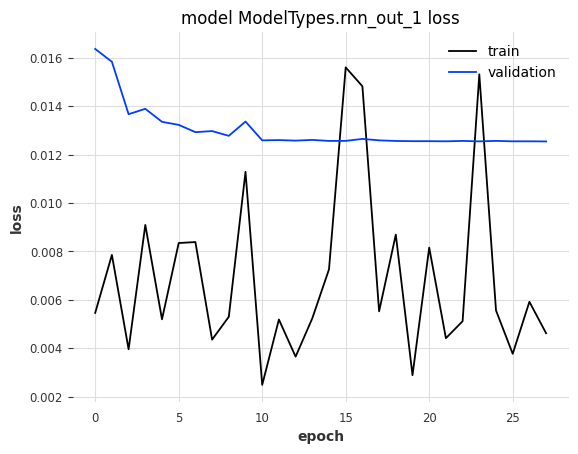

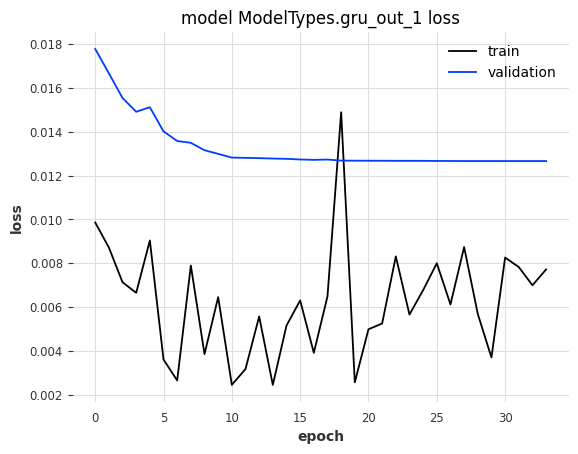

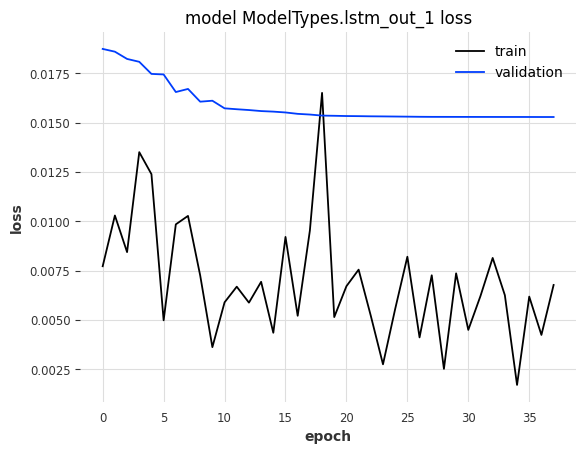

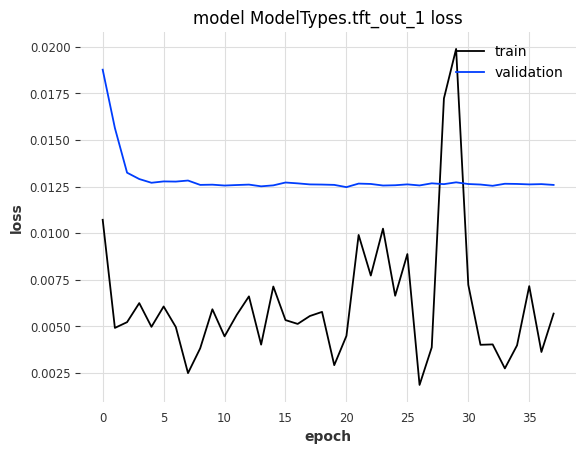

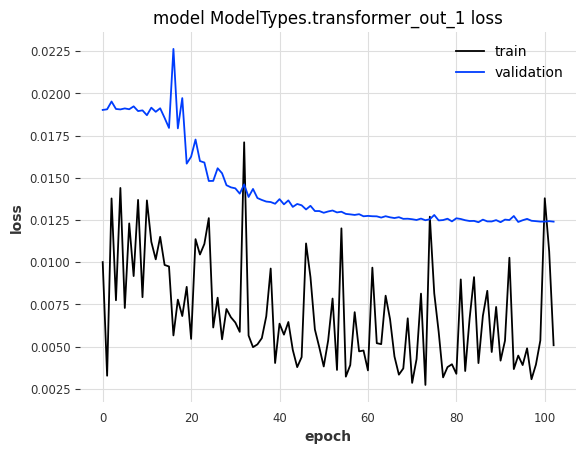

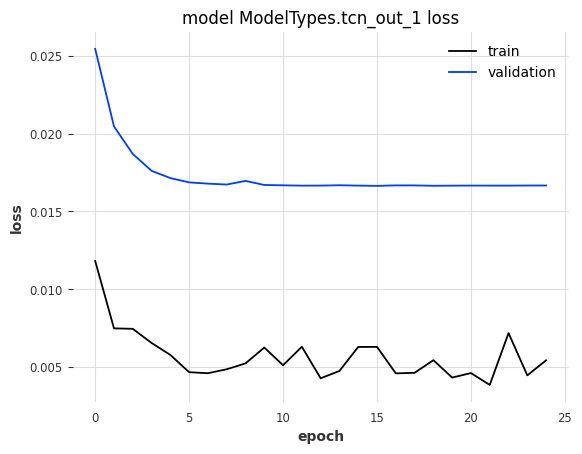

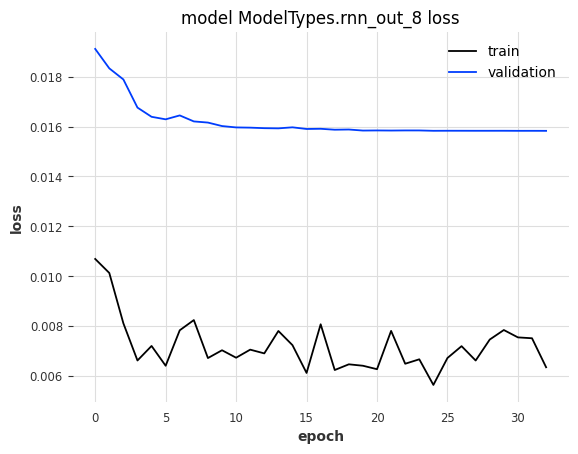

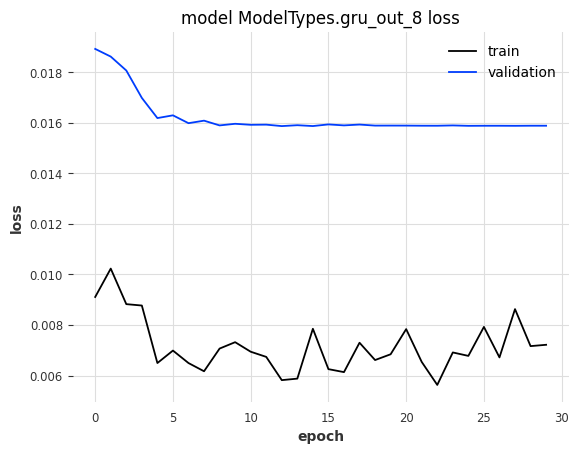

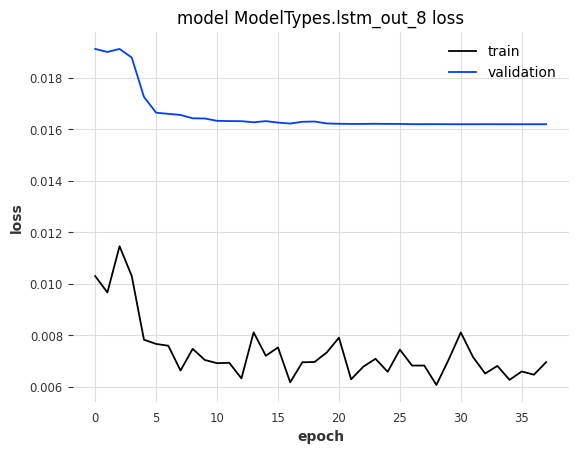

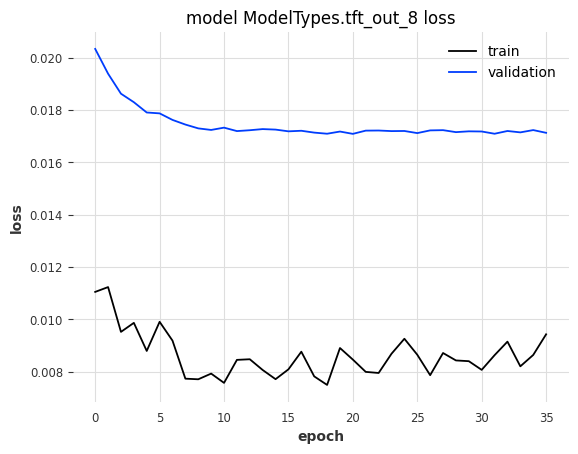

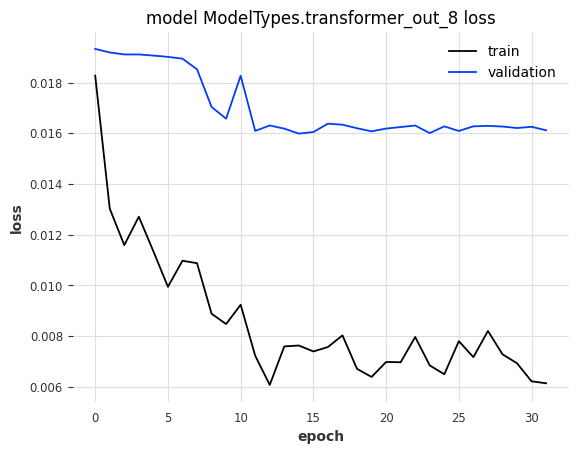

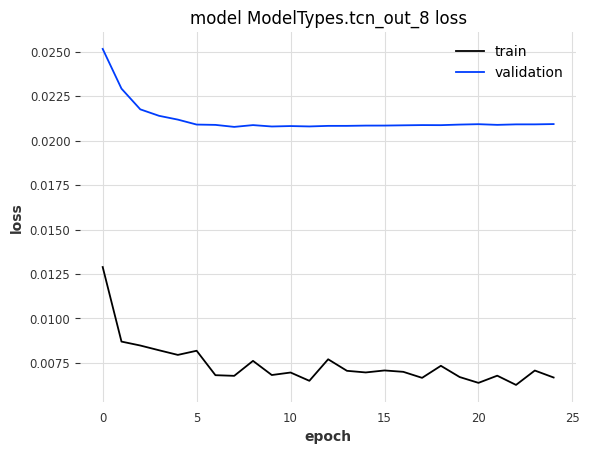

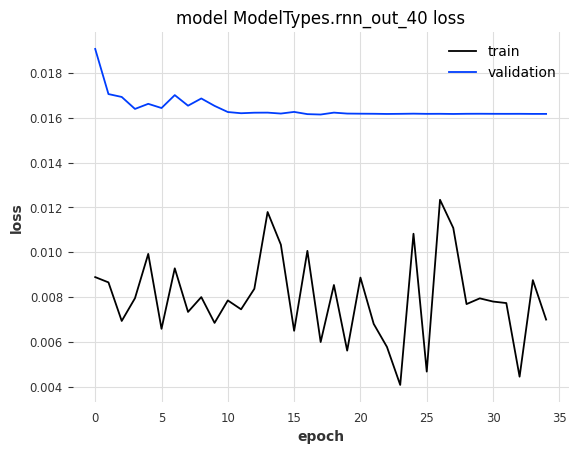

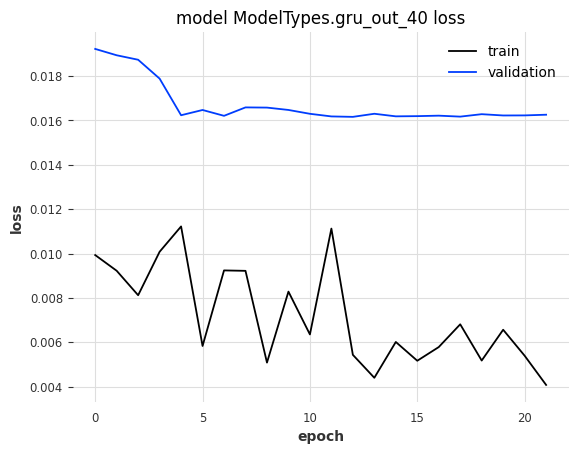

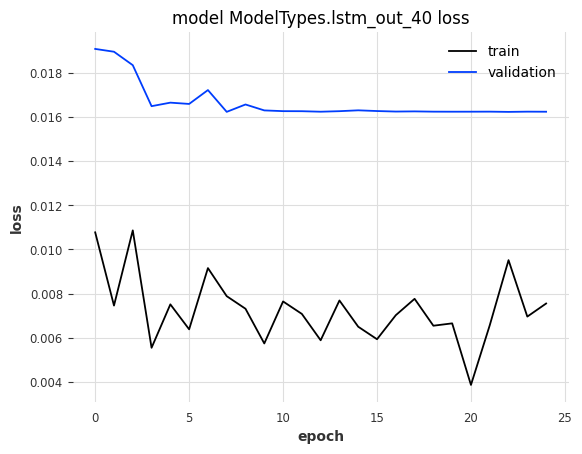

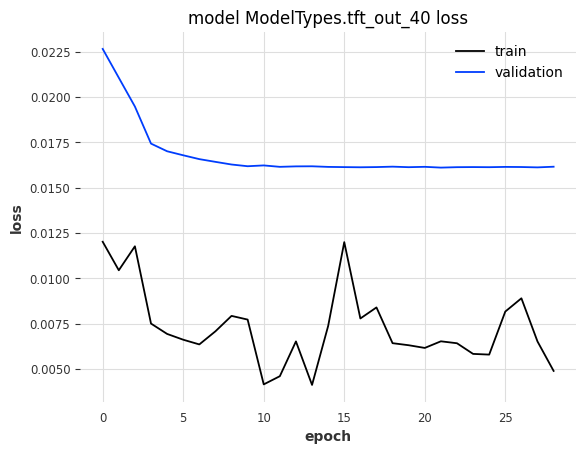

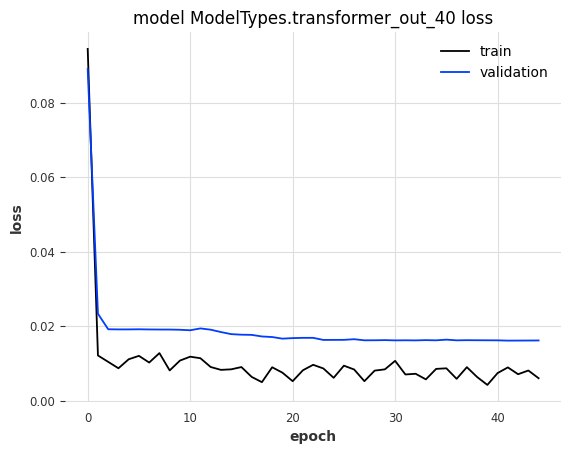

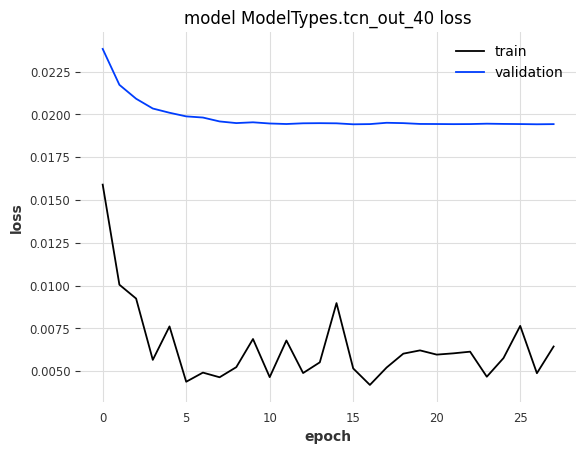

In [2]:
import joblib

plt.ioff()
loss_dict = {}
for config in MODEL_CONFIGS:
    figure = joblib.load(f"{config.result_path}/loss.pkl")
    axes = figure.get_axes()[0]
    train = axes.get_lines()[0].get_ydata()
    val = axes.get_lines()[1].get_ydata()
    loss_dict[f"{config.model_type.value} h={config.output_len}"] = (train, val)
plt.ioff()

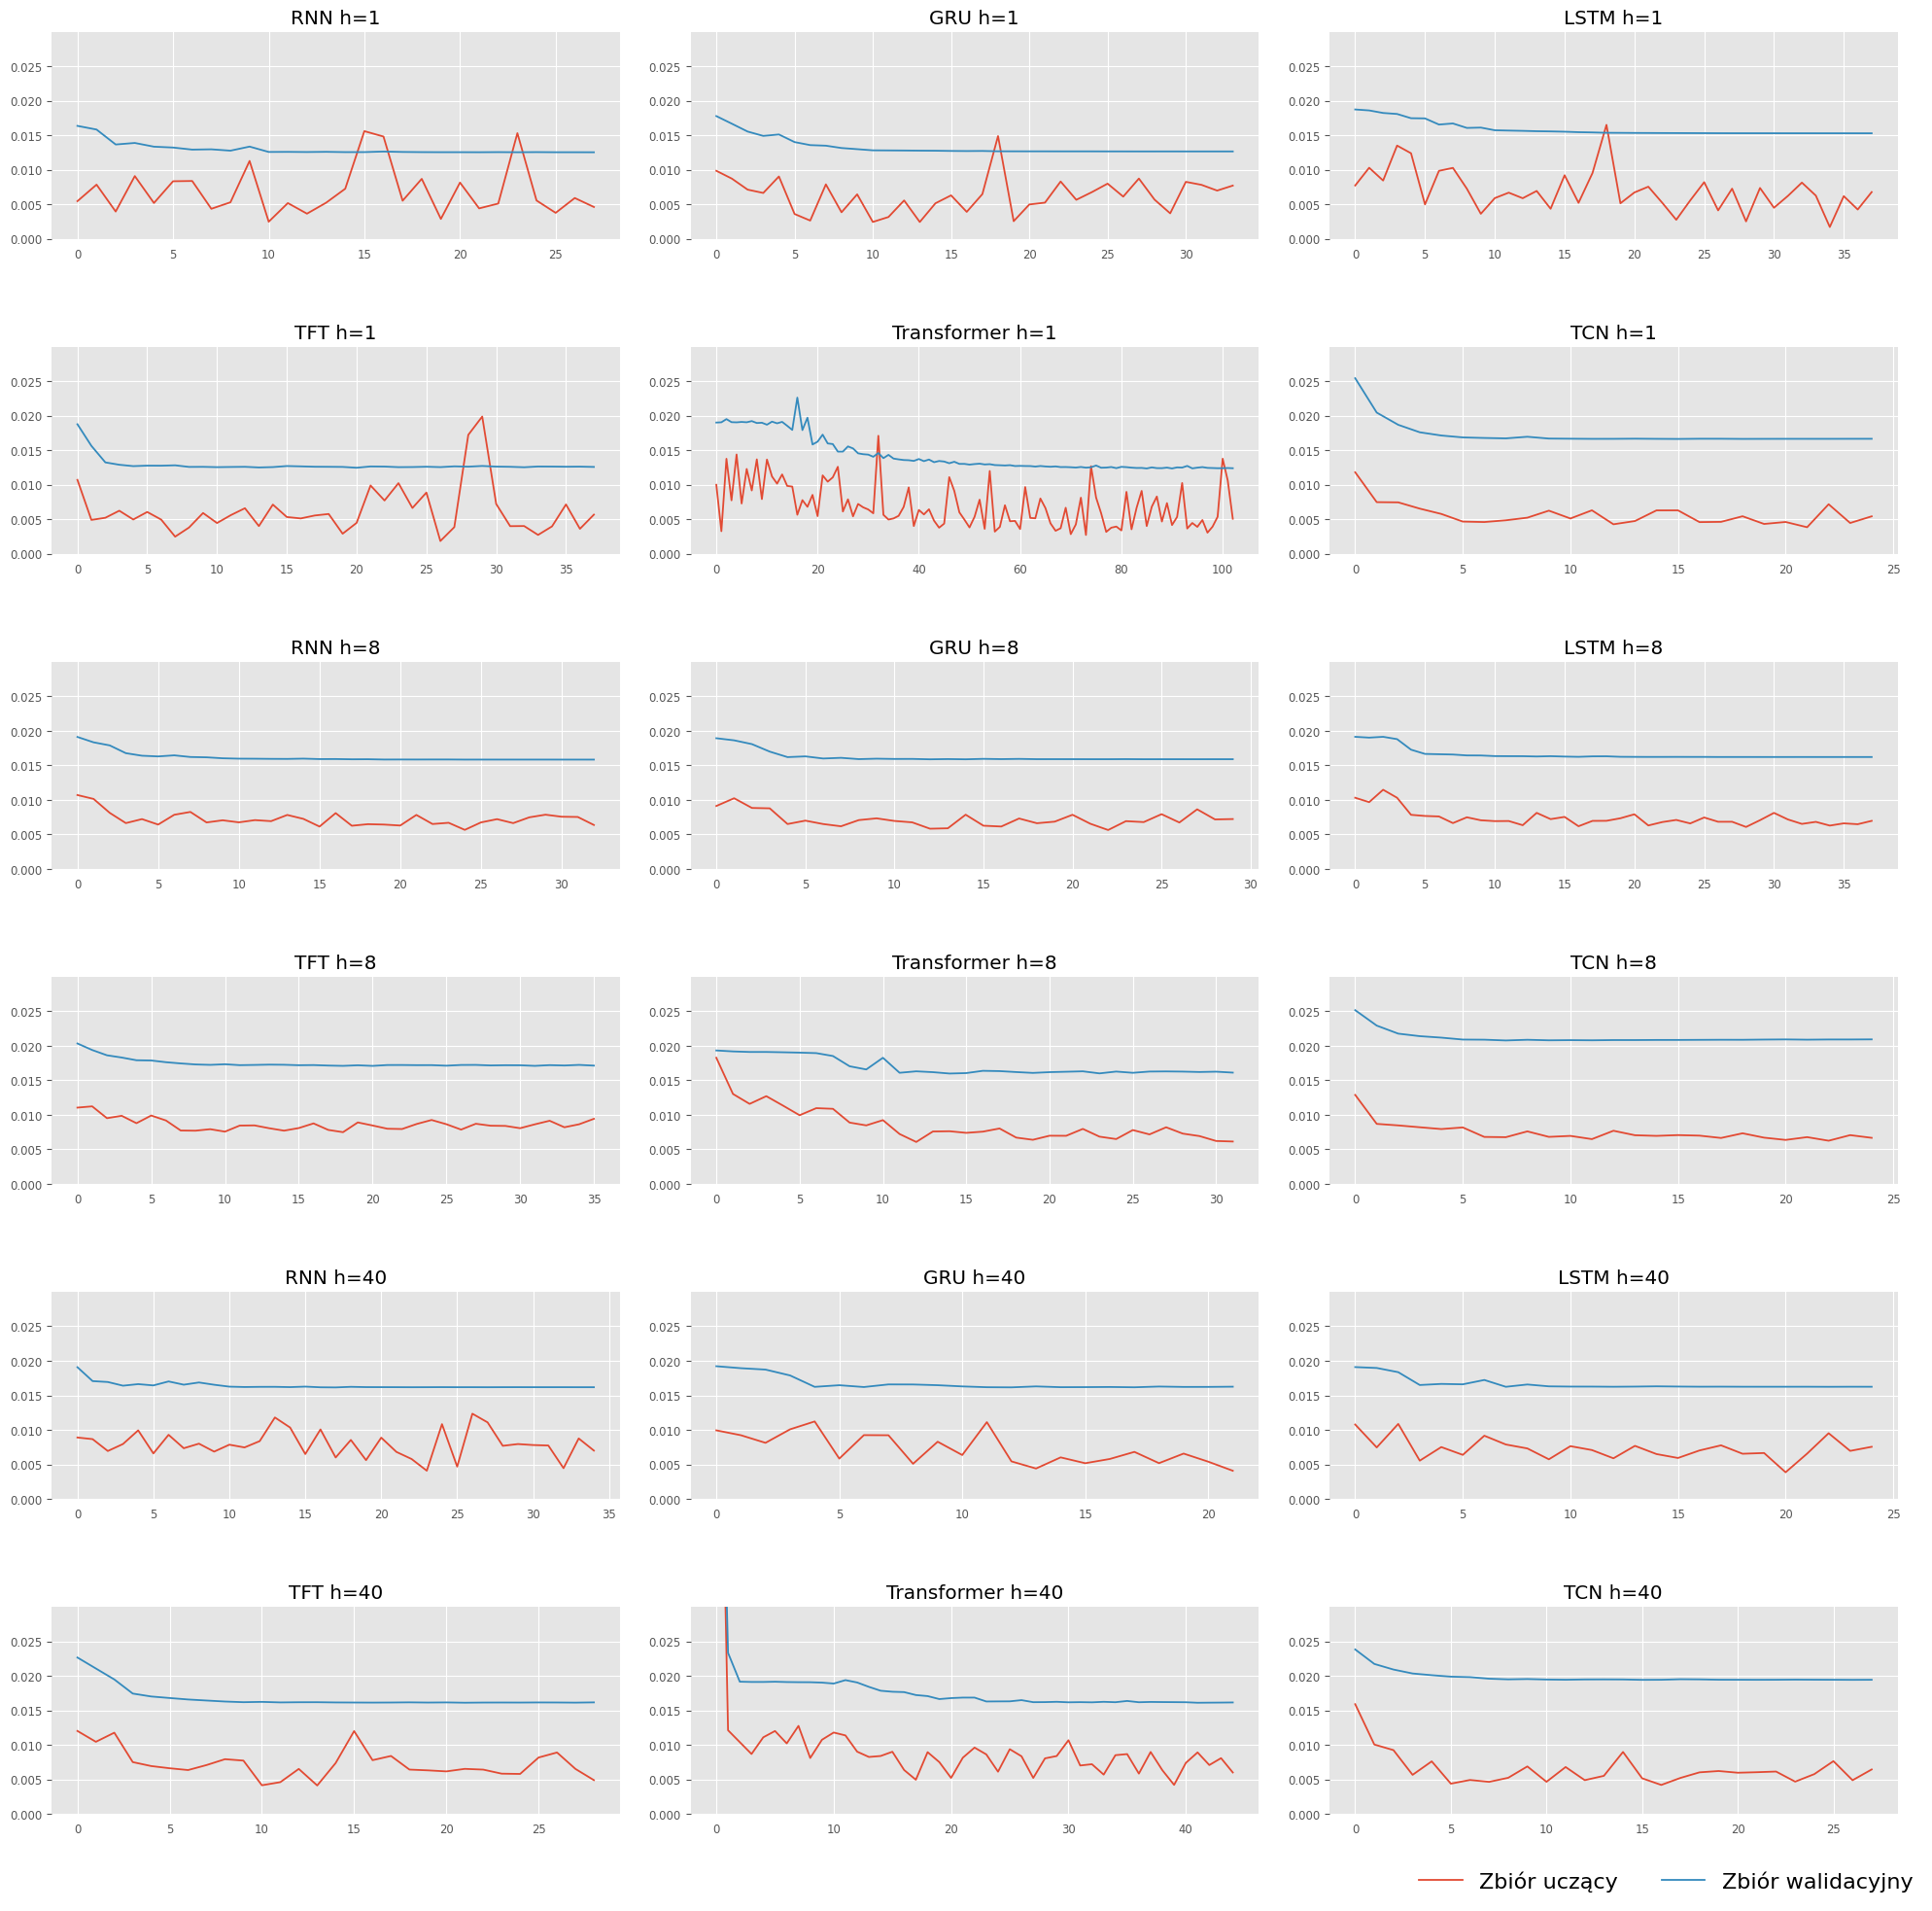

In [13]:

import numpy as np


plt.close()
plt.ion()
figure, axis = plt.subplots(6, 3)
figure.tight_layout(pad=2.0)
figure.set_figheight(20)

min_val_losses = {}

for idx, (key, value) in enumerate(loss_dict.items()):
        ax = axis[idx // 3, idx % 3]
        ax.plot(value[0])
        ax.plot(value[1])
        min_val_losses[key] = min(value[1])
        ax.set_yticks(np.arange(0, 0.03, 0.005))
        ax.set_ylim(0, 0.03)
        ax.set_title(key)

labels = ["Zbiór uczący", "Zbiór walidacyjny"]
figure.legend(labels, loc='lower right',  ncol=len(labels),  prop={'size': 16}, bbox_transform=figure.transFigure)
plt.show()

INFO:Dataset:Loading dataset from data/preprocessed/datasets.pkl
INFO:darts.models.forecasting.torch_forecasting_model:loading best-epoch=20-val_loss=0.02.ckpt
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Predicting: 0it [00:00, ?it/s]

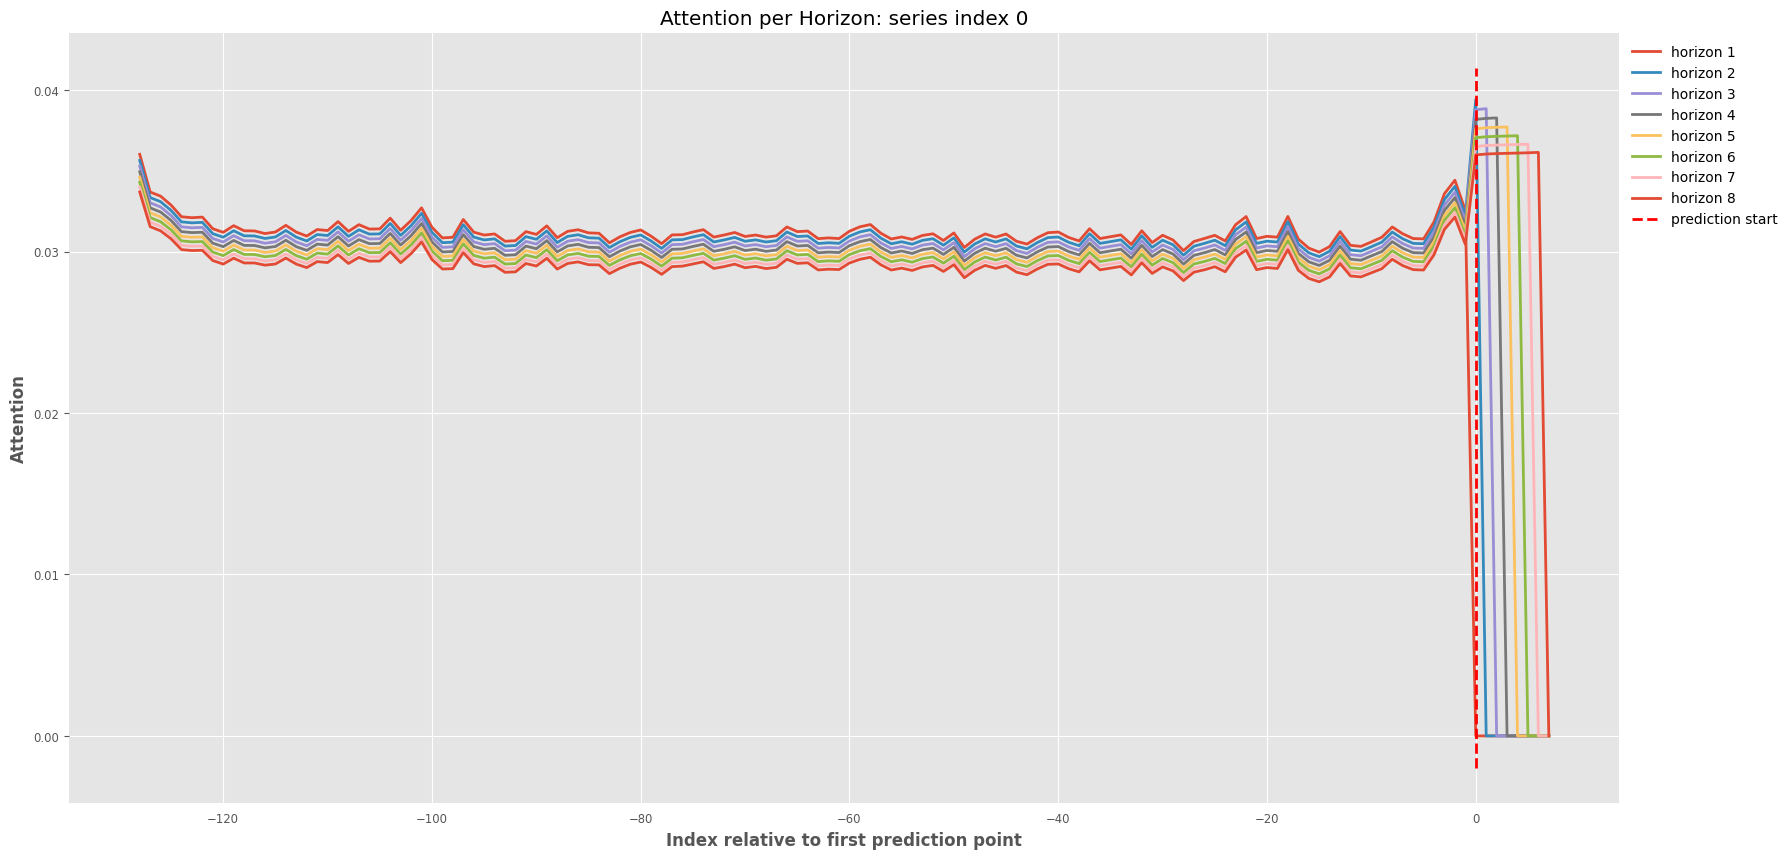

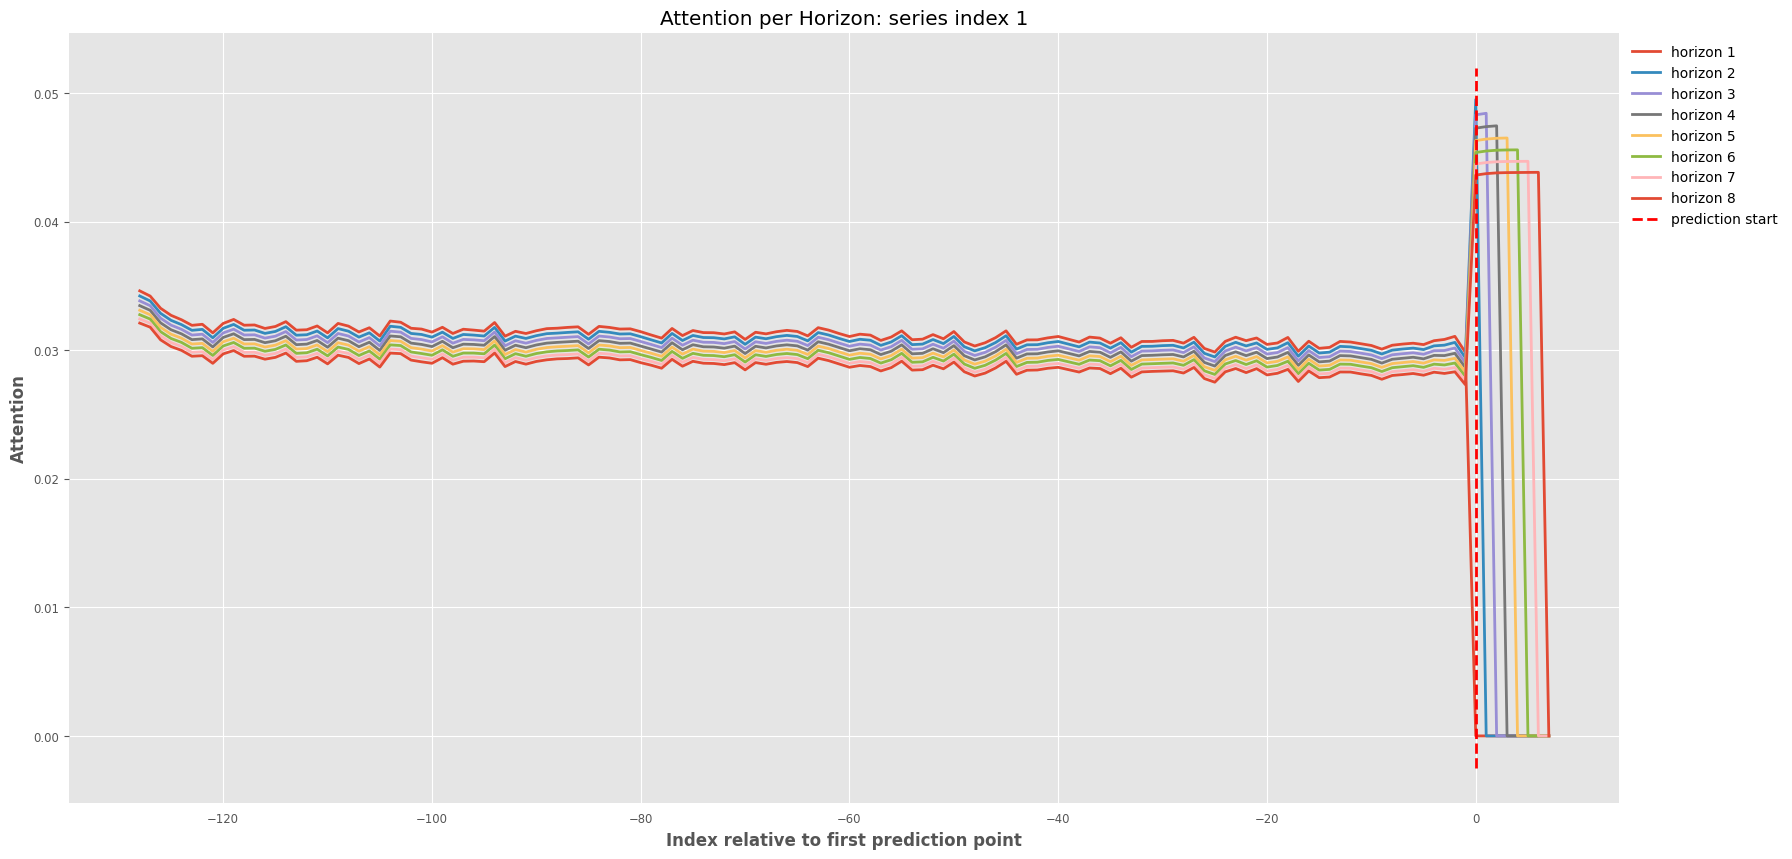

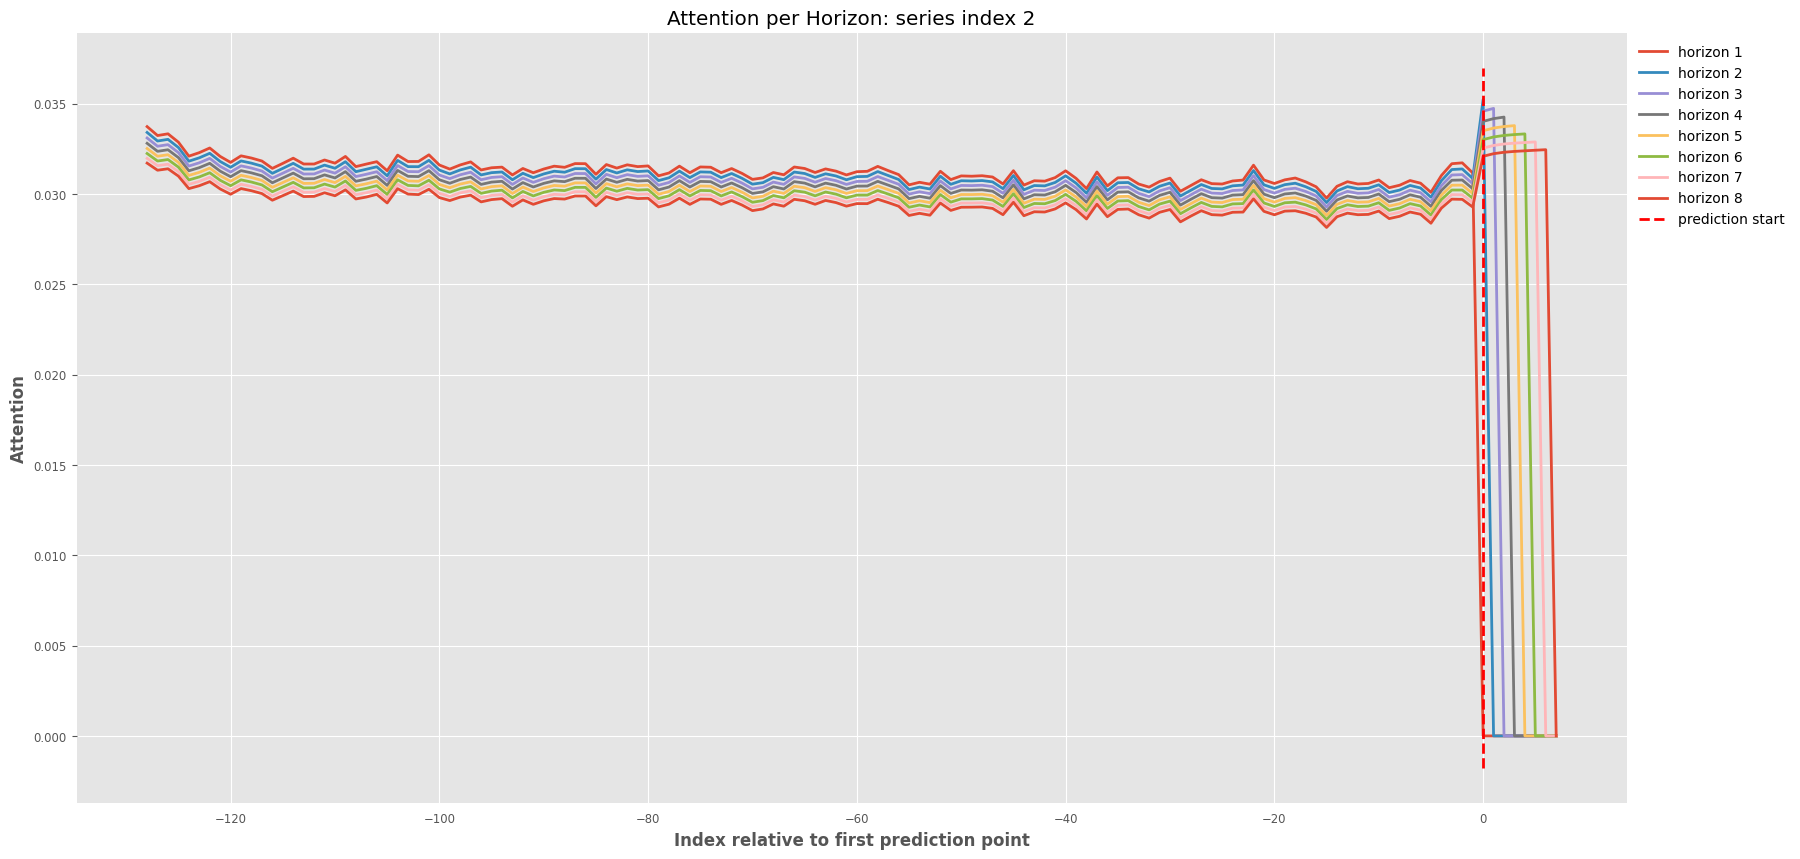

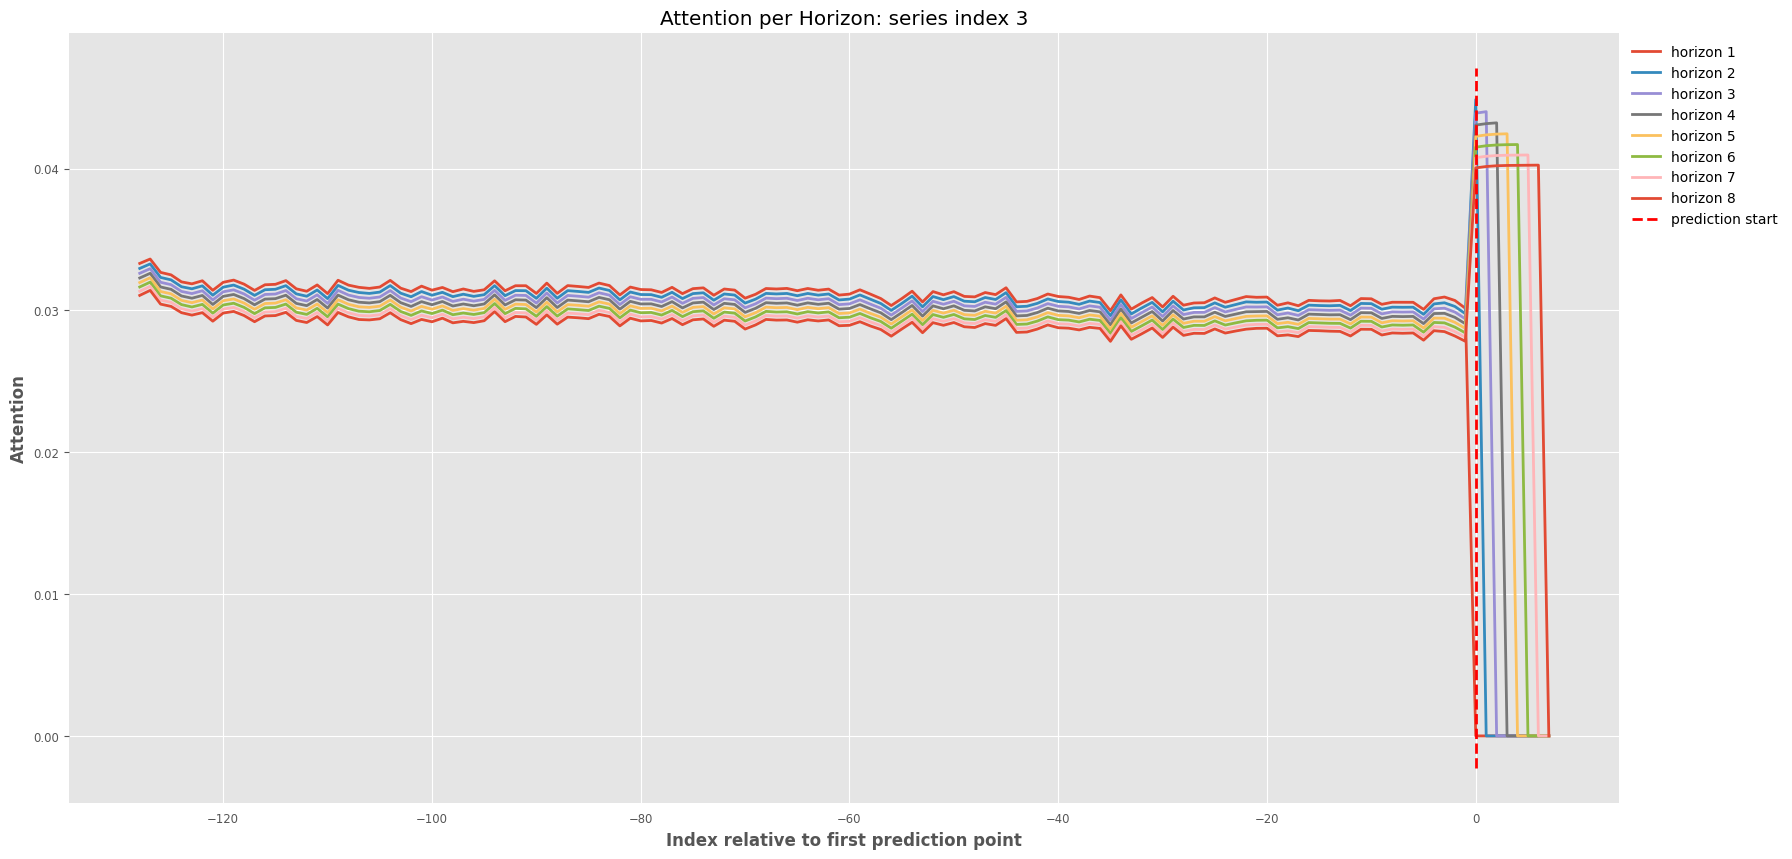

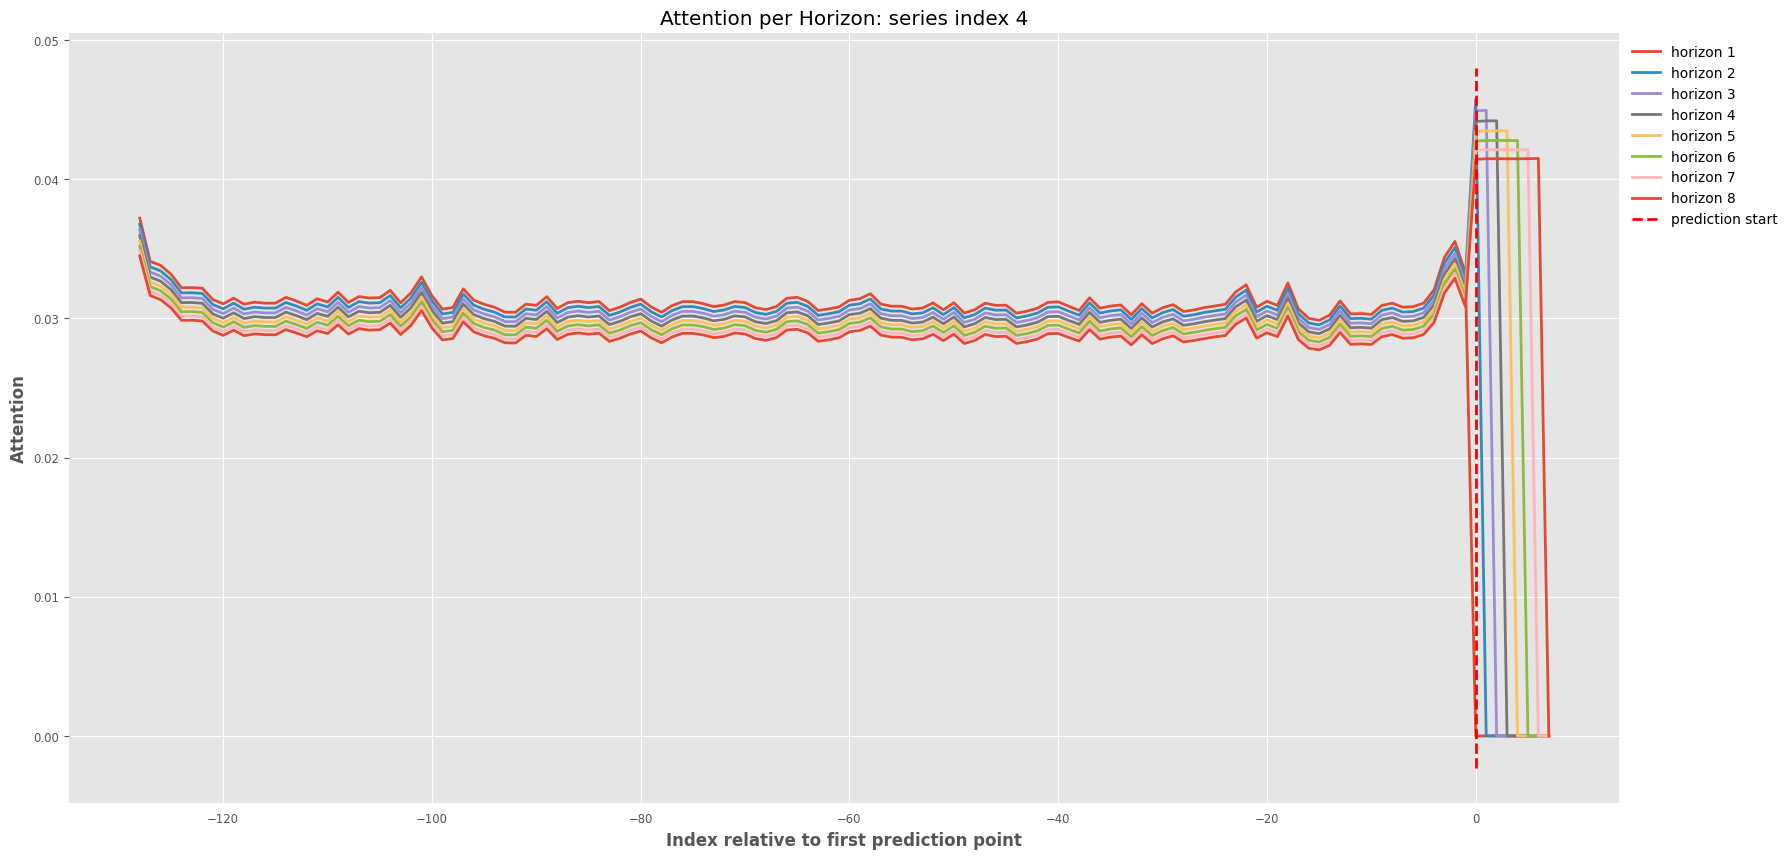

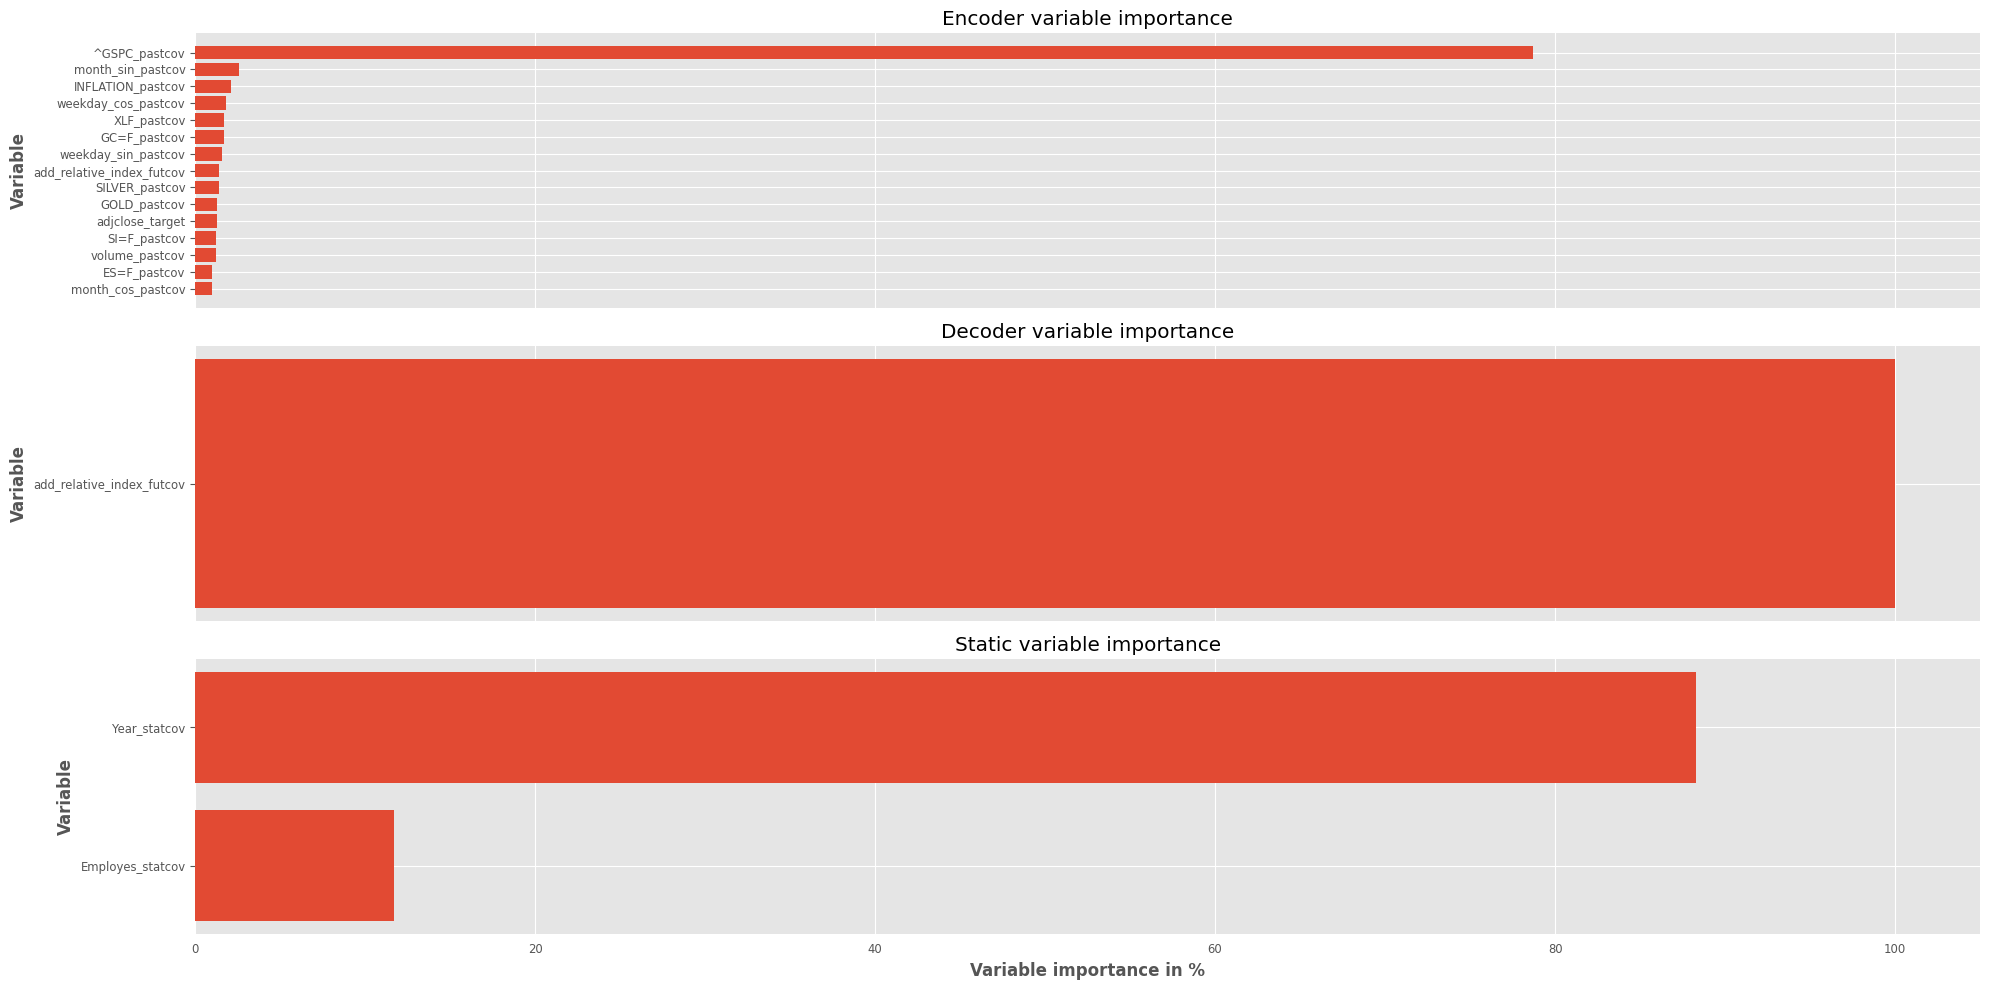

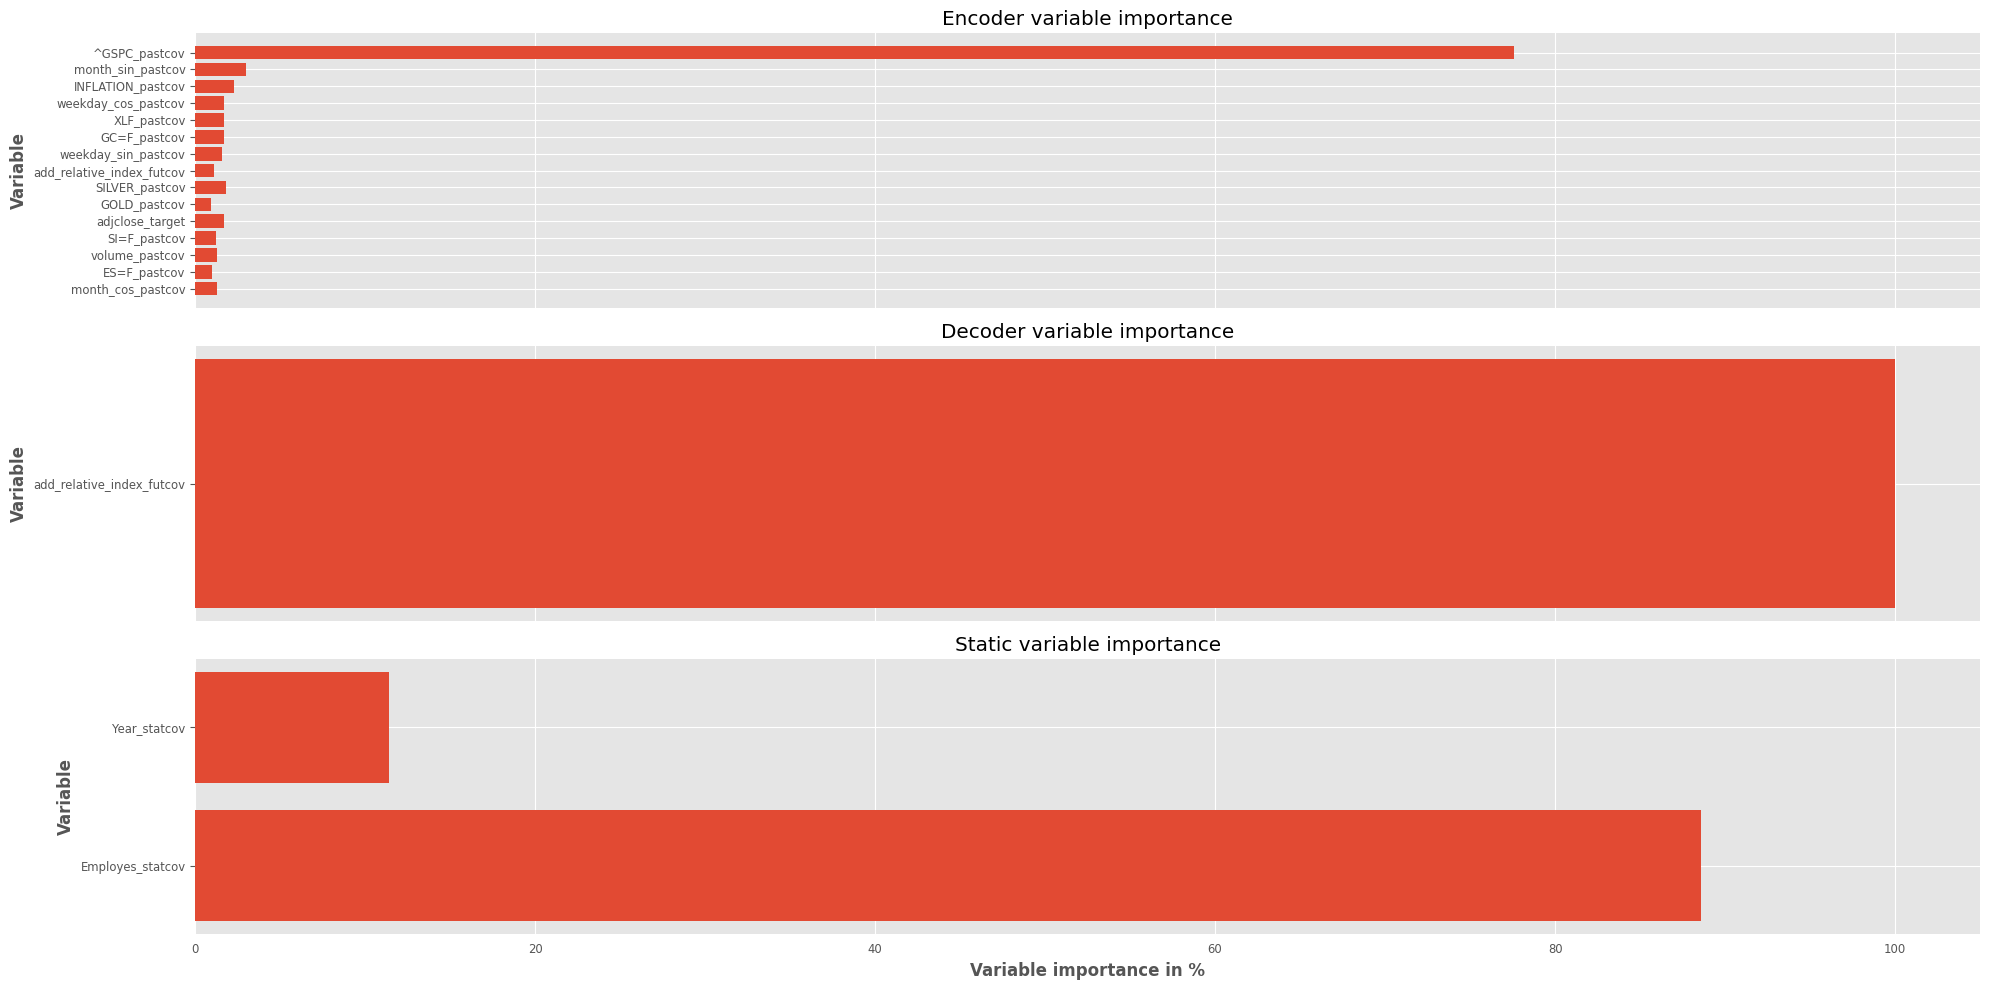

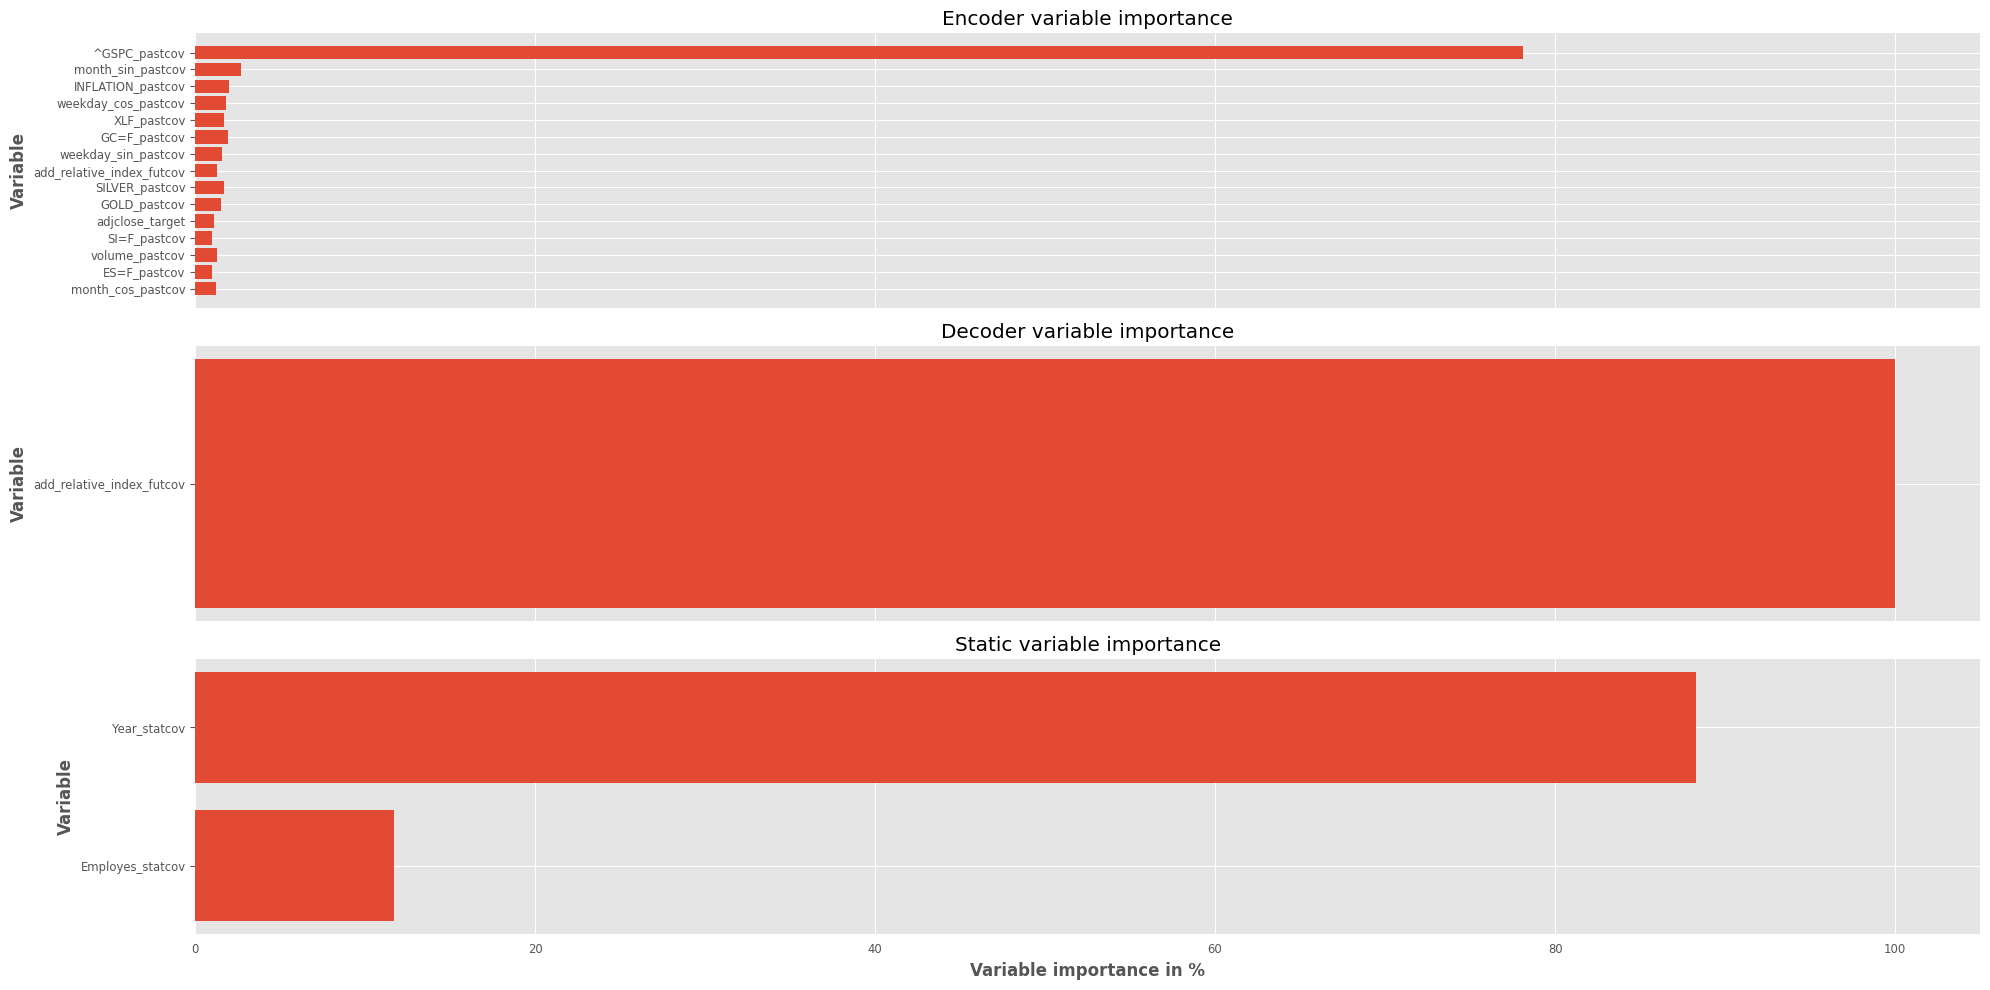

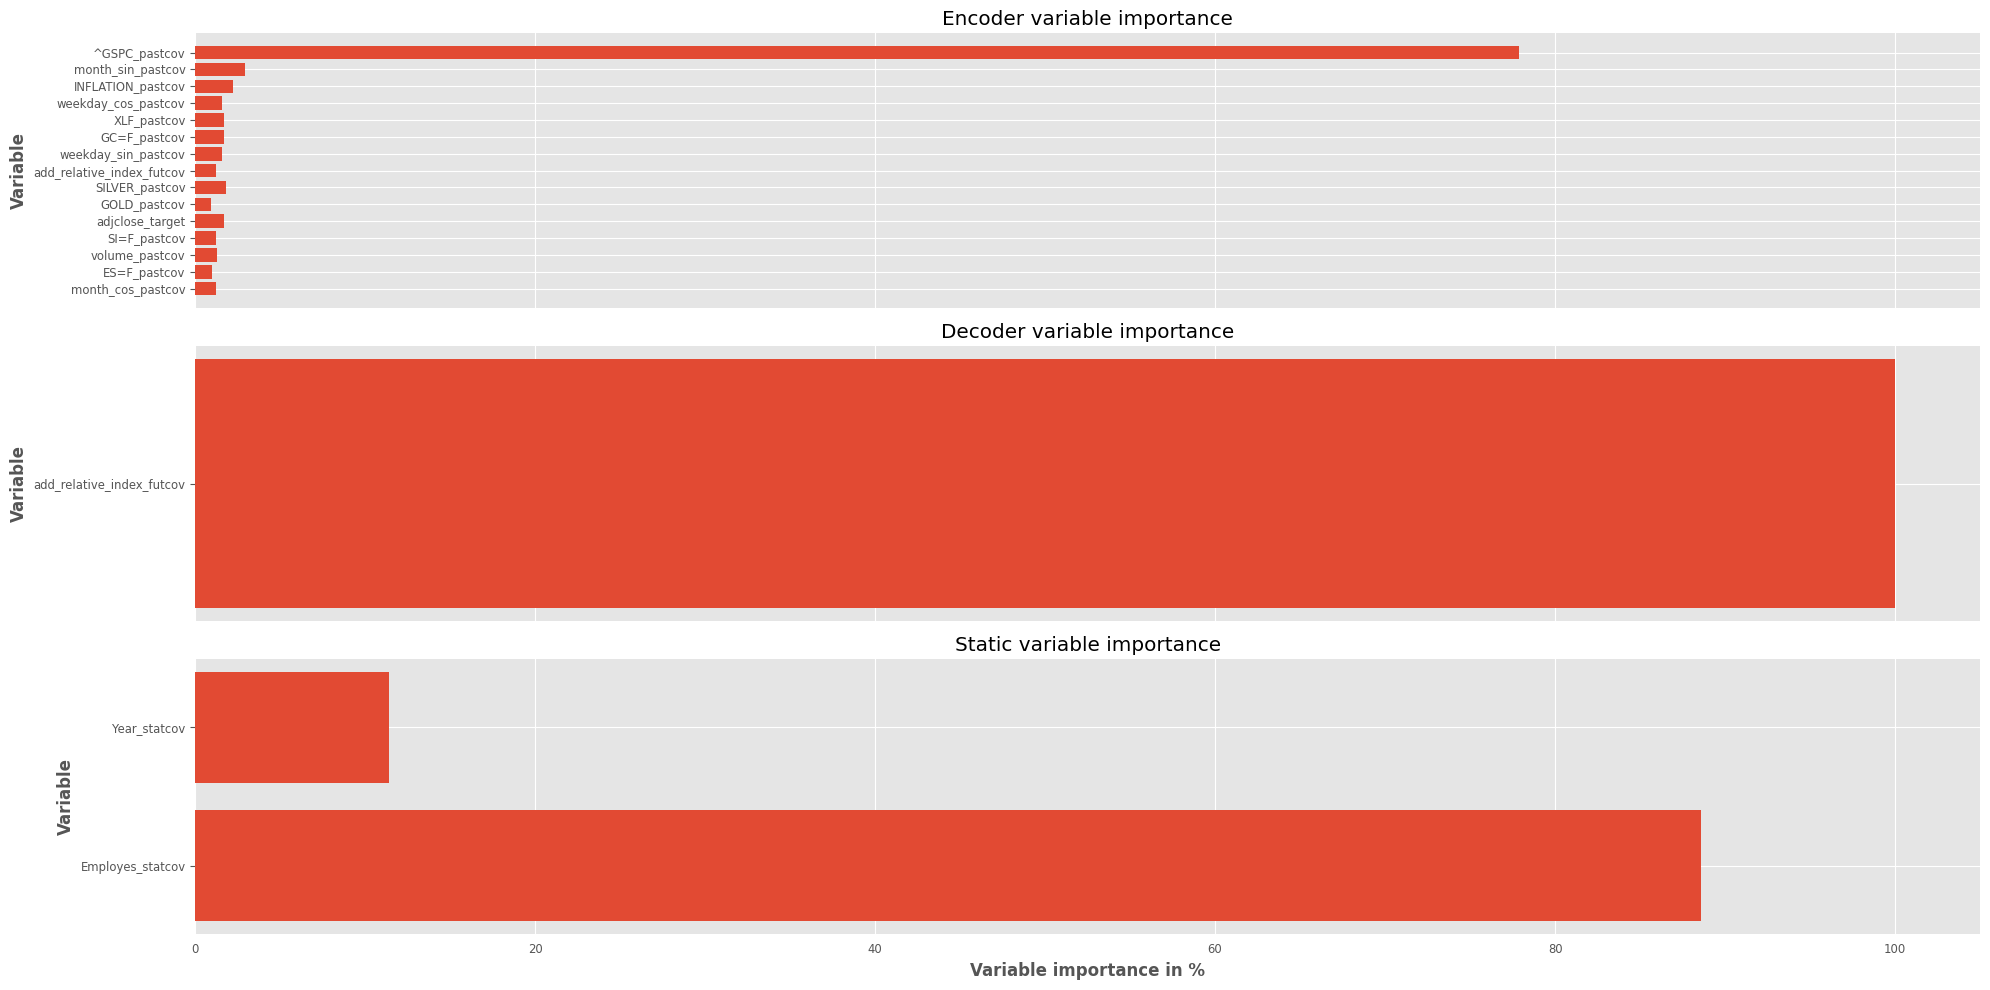

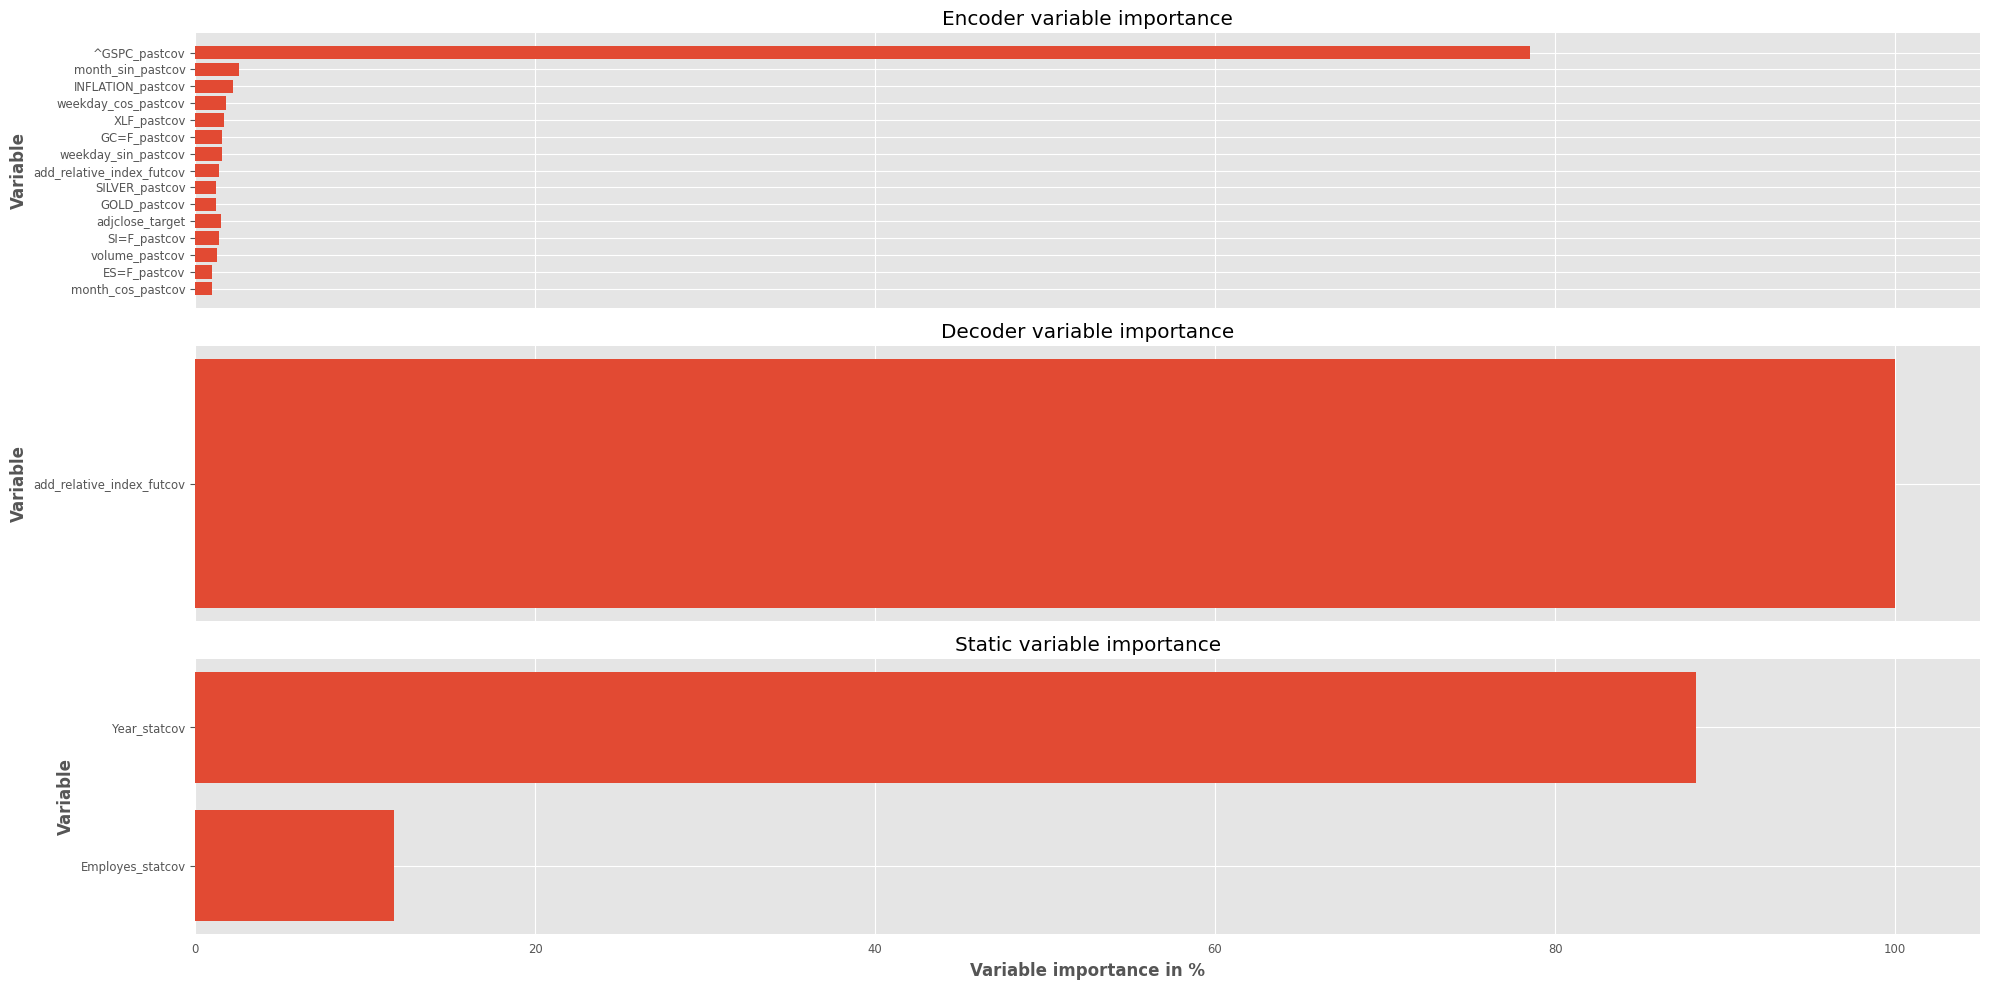

In [4]:
import darts

from darts.datasets import AirPassengersDataset
from darts.explainability.tft_explainer import TFTExplainer
from darts.models.forecasting.torch_forecasting_model import TorchForecastingModel
from datasets import SeqDataset, Datasets, DatasetAccesor, DatasetTransformer, load_datasets
from const import ModelConfig, ModelTypes
from darts.models import TFTModel
config =  ModelConfig(ModelTypes.tft, 8, hidden_state=38)

ds = load_datasets()

model = TFTModel.load_from_checkpoint(model_name=config.model_name, best=True, map_location="cpu")
model.to_cpu()
# create the explainer and generate explanations
explainer = TFTExplainer(model, ds.transformed.train, ds.covariates.train)
results = explainer.explain()
# plot the results
explainer.plot_attention(results, plot_type="all")
explainer.plot_variable_selection(results)

In [5]:
from view_results import load_results
import numpy as np
config =  ModelConfig(ModelTypes.tft, 40, hidden_state=38)
predictions = load_results(config)

In [6]:
predicted_end_value = None
real_values = None
UP = True
DOWN = False

trend = []
predicted_trend = []

for idx, series_predictions in enumerate(predictions):
    original_series = ds.original.series[idx]
    for prediction in series_predictions:
        init_value_index = original_series.get_index_at_point(prediction.start_time()) - 1
        init_value_timestamp = original_series.get_timestamp_at_point(init_value_index)
        original_init_value = original_series[init_value_timestamp].first_value()
        original_end_value = original_series[prediction.end_time()].first_value()
        predicted_end_value = prediction[prediction.end_time()].first_value()
        trend.append(original_init_value < original_end_value)
        predicted_trend.append(original_init_value < predicted_end_value)

In [7]:
acc = np.sum(np.array(trend) == np.array(predicted_trend))/ len(trend)
acc #0.43

0.49709302325581395